In [1]:
import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/AkiGoat/pytorch-unet.git

  %cd pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 74 (delta 9), reused 15 (delta 8), pack-reused 55
Receiving objects: 100% (74/74), 340.30 KiB | 4.79 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/Users/hyde-mbp/Projects/Grad/pytorch-unet


In [3]:
!ls

LICENSE                           pytorch_fcn.ipynb
README.md                         pytorch_resnet18_unet.ipynb
__pycache__                       pytorch_unet.ipynb
checkpoint.pth                    pytorch_unet.py
helper.py                         pytorch_unet_resnet18_colab.ipynb
images                            simulation.py
loss.py


In [4]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [5]:
device = torch.device("mps")

In [51]:
file_path = '/Volumes/SamDick/Grad Project/Data/U_Net/96_96/'

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
# input_images, target_masks = simulation.generate_random_data(9, 9, count=2)
input_images = np.load(file_path+'Pics.npy')
target_masks = np.load(file_path+'Masks.npy')

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

input_images shape and range (384, 96, 96, 3) -31.688776 47.60049
target_masks shape and range (384, 2, 96, 96) 0.0 1.0


In [59]:
import random
input_images_rgb_ = []
target_masks_rgb_ = []
for i in random.sample(range(len(input_images_rgb)), 3):
    input_images_rgb_.append(input_images_rgb[i])
    target_masks_rgb_.append(target_masks_rgb[i])

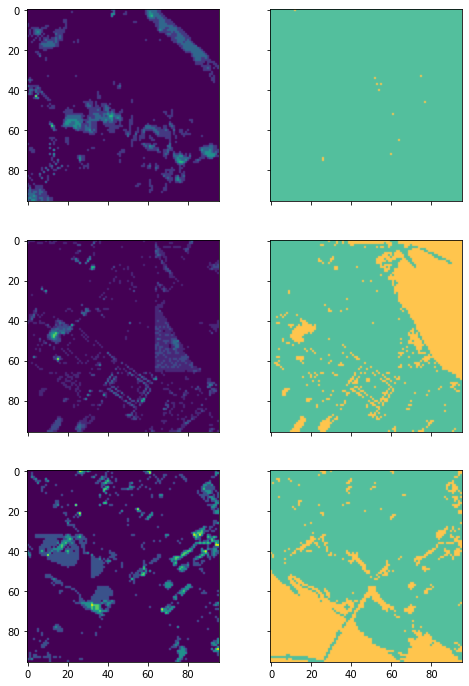

In [60]:
helper.plot_side_by_side([input_images_rgb_, target_masks_rgb_])

In [61]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class TrainDataset(Dataset):
    def __init__(self, size, transform=None):
#     self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        # input_images = np.load(io.BytesIO(uploaded['DSMs.npy']))
        # target_masks = np.load(io.BytesIO(uploaded['Masks.npy']))
        input_images = np.load(file_path+'Pics.npy')
        target_masks = np.load(file_path+'Masks.npy')
        input_images = input_images[:size]
        target_masks = target_masks[:size]
        self.input_images = input_images
        self.target_masks = target_masks
        self.transform = transform
        
    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

class ValDataset(Dataset):
    def __init__(self, size1, size2, transform=None):
#     self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
    #   input_images = np.load(io.BytesIO(uploaded['DSMs.npy']))
    #   target_masks = np.load(io.BytesIO(uploaded['Masks.npy']))
      input_images = np.load(file_path+'Pics.npy')
      target_masks = np.load(file_path+'Masks.npy')
      input_images = input_images[size1:size2]
      target_masks = target_masks[size1:size2]
      self.input_images = input_images
      self.target_masks = target_masks
      self.transform = transform
        
    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

class TestDataset(Dataset):
    def __init__(self, size1, size2, transform=None):
#     self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
    #   input_images = np.load(io.BytesIO(uploaded['DSMs.npy']))
    #   target_masks = np.load(io.BytesIO(uploaded['Masks.npy']))
      input_images = np.load(file_path+'Pics.npy')
      target_masks = np.load(file_path+'Masks.npy')
    #   input_images = input_images[-size:]
    #   target_masks = target_masks[-size:]
      input_images = input_images[size1:size2]
      target_masks = target_masks[size1:size2]
      self.input_images = input_images
      self.target_masks = target_masks
      self.transform = transform
        
    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

# train_set = SimDataset(2000, transform = trans)
# val_set = SimDataset(200, transform = trans)

train_set = TrainDataset(300, transform = trans)
val_set = ValDataset(300, 375, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [62]:
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)

torch.Size([25, 3, 96, 96]) torch.Size([25, 2, 96, 96])


torch.Size([25, 3, 96, 96]) torch.Size([25, 2, 96, 96])


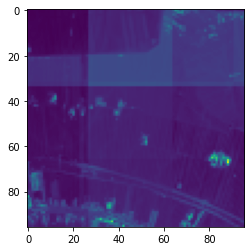

In [70]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    # [B,G,R] = np.dsplit(inp,inp.shape[-1])
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    [B,G,R] = np.dsplit(inp,inp.shape[-1])
#     print(inp.shape)
#     inp = np.clip(inp, 0, 1)
#     inp = (inp * 255).astype(np.uint8)

    return B[:,:,0] 

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[4]))
# reverse_transform(inputs[4])

In [71]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [83]:
import torch
import torch.nn as nn
import pytorch_unet

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(2)
# model = model.to(device)

device mps


In [75]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [84]:
from torchsummary import summary
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 48, 48]           9,408
            Conv2d-6           [-1, 64, 48, 48]           9,408
       BatchNorm2d-7           [-1, 64, 48, 48]             128
       BatchNorm2d-8           [-1, 64, 48, 48]             128
              ReLU-9           [-1, 64, 48, 48]               0
             ReLU-10           [-1, 64, 48, 48]               0
        MaxPool2d-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 64, 24, 24]          36,864
           Conv2d-14           [-1, 64,

In [77]:
model = model.to(device)


In [78]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [79]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 2
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train: bce: 0.698608, dice: 0.567616, loss: 0.633112
LR 0.0001
val: bce: 0.686327, dice: 0.542436, loss: 0.614382
saving best model to checkpoint.pth
0m 6s
Epoch 1/19
----------
train: bce: 0.692809, dice: 0.552547, loss: 0.622678
LR 0.0001
val: bce: 0.672049, dice: 0.559069, loss: 0.615559
0m 2s
Epoch 2/19
----------
train: bce: 0.684092, dice: 0.546967, loss: 0.615530
LR 0.0001
val: bce: 0.665109, dice: 0.536448, loss: 0.600779
saving best model to checkpoint.pth
0m 2s
Epoch 3/19
----------
train: bce: 0.641091, dice: 0.542493, loss: 0.591792
LR 0.0001
val: bce: 0.623210, dice: 0.543810, loss: 0.583510
saving best model to checkpoint.pth
0m 2s
Epoch 4/19
----------
train: bce: 0.596384, dice: 0.533160, loss: 0.564772
LR 0.0001
val: bce: 0.663051, dice: 0.543844, loss: 0.603448
0m 2s
Epoch 5/19
----------
train: bce: 0.540338, dice: 0.512618, loss: 0.526478
LR 0.0001
val: bce: 0.681486, dice: 0.531983, loss: 0.606734
0m 2s
Epoch 6/19
----------
train: bce: 0.4775

In [80]:
import math

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = TestDataset(375, 380, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
# input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
input_images_rgb_ = [x.astype(np.uint8) for x in input_images][375:380]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

inputs.shape torch.Size([5, 3, 96, 96])
labels.shape torch.Size([5, 2, 96, 96])
pred.shape (5, 2, 96, 96)


In [49]:
input_images_rgb[0].shape

(64, 64, 3)

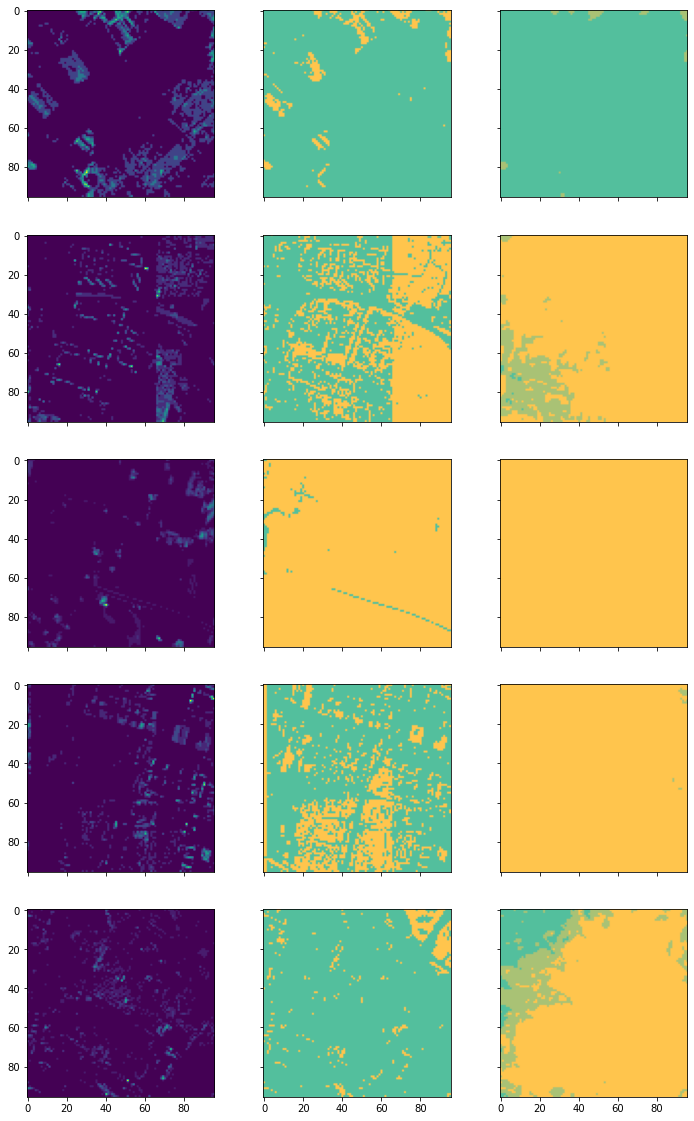

In [81]:
helper.plot_side_by_side([input_images_rgb_, target_masks_rgb, pred_rgb])

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
# input_images, target_masks = simulation.generate_random_data(9, 9, count=2)
input_images = np.load(file_path+'DSMs.npy')
target_masks = np.load(file_path+'Masks.npy')

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

input_images shape and range (195, 8, 8, 3) -0.750704 32.94221
target_masks shape and range (195, 2, 8, 8) 0.0 1.0


In [40]:
import random
input_images_rgb_ = []
target_masks_rgb_ = []
for i in random.sample(range(len(input_images_rgb)), 3):
    print(i)
    input_images_rgb_.append(input_images_rgb[i])
    target_masks_rgb_.append(target_masks_rgb[i])

109
57
171


In [42]:
target_masks[171]

array([[[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]],

       [[1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1.]]], dtype=float32)

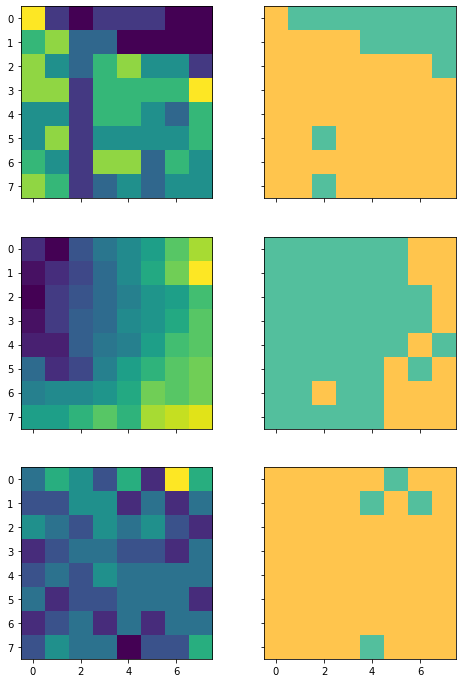

In [41]:
helper.plot_side_by_side([input_images_rgb_, target_masks_rgb_])

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class TrainDataset(Dataset):
    def __init__(self, size, transform=None):
#     self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        input_images = np.load(file_path+'DSMs.npy')[:size]
        target_masks = np.load(file_path+'Masks.npy')[:size]
        self.input_images = input_images
        self.target_masks = target_masks
        self.transform = transform
        
    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

class TestDataset(Dataset):
    def __init__(self, size, transform=None):
#     self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        input_images = np.load(file_path+'DSMs.npy')[-size:]
        target_masks = np.load(file_path+'Masks.npy')[-size:]
        self.input_images = input_images
        self.target_masks = target_masks
        self.transform = transform
        
    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

# train_set = SimDataset(2000, transform = trans)
# val_set = SimDataset(200, transform = trans)

train_set = TrainDataset(100, transform = trans)
test_set = TestDataset(25, transform = trans)

image_datasets = {
  'train': train_set, 'test': test_set
}

batch_size = 5

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [22]:
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)

torch.Size([5, 3, 8, 8]) torch.Size([5, 2, 8, 8])


torch.Size([5, 3, 8, 8]) torch.Size([5, 2, 8, 8])


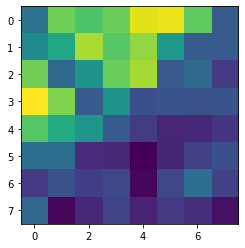

In [23]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    [B,G,R] = np.dsplit(inp,inp.shape[-1])
    
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     print(inp.shape)
#     inp = np.clip(inp, 0, 1)
#     inp = (inp * 255).astype(np.uint8)

    return B

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[4]))
# reverse_transform(inputs[4])

In [24]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
#         self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
#         self.layer3_1x1 = convrelu(256, 256, 1, 0)
#         self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
#         self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
#         self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 128, 128, 3, 1)
        self.conv_up0 = convrelu(64 + 128, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        
        layer2 = self.layer2_1x1(layer2)
        x = self.upsample(layer2)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
#         layer3 = self.layer3(layer2)
#         layer4 = self.layer4(layer3)

#         layer4 = self.layer4_1x1(layer4)
#         x = self.upsample(layer4)
#         layer3 = self.layer3_1x1(layer3)
#         x = torch.cat([x, layer3], dim=1)
#         x = self.conv_up3(x)

#         x = self.upsample(x)
#         layer2 = self.layer2_1x1(layer2)
#         x = torch.cat([x, layer2], dim=1)
#         x = self.conv_up2(x)

#         x = self.upsample(x)
#         layer1 = self.layer1_1x1(layer1)
#         x = torch.cat([x, layer1], dim=1)
#         x = self.conv_up1(x)

#         x = self.upsample(x)
#         layer0 = self.layer0_1x1(layer0)
#         x = torch.cat([x, layer0], dim=1)
#         x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [25]:
import torch
import torch.nn as nn
import pytorch_unet

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('device', device)

model = ResNetUNet(2)
model = model.to(device)

In [17]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [26]:
from torchsummary import summary
summary(model, input_size=(3, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           1,792
              ReLU-2             [-1, 64, 8, 8]               0
            Conv2d-3             [-1, 64, 8, 8]          36,928
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]           9,408
            Conv2d-6             [-1, 64, 4, 4]           9,408
       BatchNorm2d-7             [-1, 64, 4, 4]             128
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
             ReLU-10             [-1, 64, 4, 4]               0
        MaxPool2d-11             [-1, 64, 2, 2]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13             [-1, 64, 2, 2]          36,864
           Conv2d-14             [-1, 6

In [27]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best test loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [28]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 2
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train: bce: 0.661390, dice: 0.548547, loss: 0.604968
LR 0.0001
test: bce: 0.908499, dice: 0.597386, loss: 0.752943
0m 3s
Epoch 1/9
----------
train: bce: 0.648958, dice: 0.529883, loss: 0.589421
LR 0.0001
test: bce: 0.931699, dice: 0.612311, loss: 0.772005
0m 3s
Epoch 2/9
----------
train: bce: 0.638504, dice: 0.534457, loss: 0.586480
LR 0.0001
test: bce: 0.905077, dice: 0.603997, loss: 0.754537
0m 3s
Epoch 3/9
----------
train: bce: 0.636921, dice: 0.529521, loss: 0.583221
LR 0.0001
test: bce: 0.971709, dice: 0.609161, loss: 0.790435
0m 3s
Epoch 4/9
----------
train: bce: 0.632208, dice: 0.528701, loss: 0.580454
LR 0.0001
test: bce: 0.955826, dice: 0.609313, loss: 0.782569
0m 3s
Epoch 5/9
----------
train: bce: 0.620735, dice: 0.526186, loss: 0.573460
LR 0.0001
test: bce: 0.942673, dice: 0.609443, loss: 0.776058
0m 3s
Epoch 6/9
----------
train: bce: 0.610426, dice: 0.524870, loss: 0.567648
LR 0.0001
test: bce: 0.942296, dice: 0.606929, loss: 0.774613
0m 3s
Epoch 

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'